In [33]:
#Imports and gym creation
import gym
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import tensorflow as tf
from tensorflow import keras
#from keras.models import Sequential
#from keras.layers import Dense
#from keras.optimizers import Adam
import random

#Create Gym
from gym import wrappers
envCartPole = gym.make('CartPole-v1')
envCartPole.seed(50)

[50]

In [34]:
EPISODES = 500
TRAIN_END = 0

In [35]:
def discount_rate(): #Gamma
    return 0.95

def learning_rate(): #Alpha
    return 0.001

def batch_size():
    return 24

In [36]:
class DoubleDeepQNetwork():
    def __init__(self, states, actions, alpha, gamma, epsilon,epsilon_min, epsilon_decay):
        self.nS = states
        self.nA = actions
        self.memory = deque([], maxlen=2500)
        self.alpha = alpha
        self.gamma = gamma
        #Explore/Exploit
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.model = self.build_model()
        self.model_target = self.build_model() #Second (target) neural network
        self.update_target_from_model() #Update weights
        self.loss = []
        
    def build_model(self):
        model = keras.Sequential() #linear stack of layers https://keras.io/models/sequential/
        model.add(keras.layers.Dense(24, input_dim=self.nS, activation='relu')) #[Input] -> Layer 1
        #   Dense: Densely connected layer https://keras.io/layers/core/
        #   24: Number of neurons
        #   input_dim: Number of input variables
        #   activation: Rectified Linear Unit (relu) ranges >= 0
        model.add(keras.layers.Dense(24, activation='relu')) #Layer 2 -> 3
        model.add(keras.layers.Dense(self.nA, activation='linear')) #Layer 3 -> [output]
        #   Size has to match the output (different actions)
        #   Linear activation on the last layer
        model.compile(loss='mean_squared_error', #Loss function: Mean Squared Error
                      optimizer=keras.optimizers.Adam(lr=self.alpha)) #Optimaizer: Adam (Feel free to check other options)
        return model

    def update_target_from_model(self):
        #Update the target model from the base model
        self.model_target.set_weights( self.model.get_weights() )

    def action(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.nA) #Explore
        action_vals = self.model.predict(state) #Exploit: Use the NN to predict the correct action from this state
        return np.argmax(action_vals[0])

    def test_action(self, state): #Exploit
        action_vals = self.model.predict(state)
        return np.argmax(action_vals[0])

    def store(self, state, action, reward, nstate, done):
        #Store the experience in memory
        self.memory.append( (state, action, reward, nstate, done) )

    def experience_replay(self, batch_size):
        #Execute the experience replay
        minibatch = random.sample( self.memory, batch_size ) #Randomly sample from memory

        #Convert to numpy for speed by vectorization
        x = []
        y = []
        np_array = np.array(minibatch)
        st = np.zeros((0,self.nS)) #States
        nst = np.zeros( (0,self.nS) )#Next States
        for i in range(len(np_array)): #Creating the state and next state np arrays
            st = np.append( st, np_array[i,0], axis=0)
            nst = np.append( nst, np_array[i,3], axis=0)
        st_predict = self.model.predict(st) #Here is the speedup! I can predict on the ENTIRE batch
        nst_predict = self.model.predict(nst)
        nst_predict_target = self.model_target.predict(nst) #Predict from the TARGET
        index = 0
        for state, action, reward, nstate, done in minibatch:
            x.append(state)
            #Predict from state
            nst_action_predict_target = nst_predict_target[index]
            nst_action_predict_model = nst_predict[index]
            if done == True: #Terminal: Just assign reward much like {* (not done) - QB[state][action]}
                target = reward
            else:   #Non terminal
                target = reward + self.gamma * nst_action_predict_target[np.argmax(nst_action_predict_model)] #Using Q to get T is Double DQN
            target_f = st_predict[index]
            target_f[action] = target
            y.append(target_f)
            index += 1
        #Reshape for Keras Fit
        x_reshape = np.array(x).reshape(batch_size,self.nS)
        y_reshape = np.array(y)
        epoch_count = 1
        hist = self.model.fit(x_reshape, y_reshape, epochs=epoch_count, verbose=0)
        #Graph Losses
        for i in range(epoch_count):
            self.loss.append( hist.history['loss'][i] )
        #Decay Epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [37]:
#Create the agents
nS = envCartPole.observation_space.shape[0] #This is only 4
nA = envCartPole.action_space.n #Actions
dqn1 = DoubleDeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.005, 0.995 )
dqn2 = DoubleDeepQNetwork(nS, nA, learning_rate(), discount_rate(), 1, 0.005, 0.995 )


batch_size = batch_size()

In [38]:
#Trainin
rewards = [] #Store rewards for graphing
epsilons = [] # Store the Explore/Exploit
TEST_Episodes = 0
for e in range(EPISODES):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS]) # Resize to store in memory to pass to .predict
    tot_rewards = 0
    prev_action = 0
    for time in range(210): #200 is when you "solve" the game. This can continue forever as far as I know
        action1 = dqn1.action(state)
        action2 = dqn2.action(state)

        if ((action1==0 and action2==0) or (action1==1 and action2==1)):
          action=prev_action
        elif (action1==1 and action2==0):
          action=0
        else:
          action=1  
        prev_action = action
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape(nstate, [1, nS])
        tot_rewards += reward
        dqn1.store(state, action1, reward, nstate, done) # Resize to store in memory to pass to .predict
        dqn2.store(state, action2, reward, nstate, done) # Resize to store in memory to pass to .predict
        state = nstate
        #done: CartPole fell. 
        #time == 209: CartPole stayed upright
        if done or time == 209:
            rewards.append(tot_rewards)
            epsilons.append(dqn1.epsilon)
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e, EPISODES, tot_rewards, dqn1.epsilon))
            break
        #Experience Replay
        if len(dqn1.memory) > batch_size:
            dqn1.experience_replay(batch_size)
        if len(dqn2.memory) > batch_size:    
            dqn2.experience_replay(batch_size)
    #Update the weights after each episode (You can configure this for x steps as well
    dqn1.update_target_from_model()
    dqn2.update_target_from_model()
    #If our current NN passes we are done
    #I am going to use the last 5 runs
    if len(rewards) > 5 and np.average(rewards[-5:]) > 195:
        #Set the rest of the EPISODES for testing
        TEST_Episodes = EPISODES - e
        TRAIN_END = e
        break

episode: 0/500, score: 17.0, e: 1
episode: 1/500, score: 11.0, e: 0.985074875
episode: 2/500, score: 11.0, e: 0.9369146928798039
episode: 3/500, score: 26.0, e: 0.8265651079747222
episode: 4/500, score: 16.0, e: 0.7666961448653229
episode: 5/500, score: 16.0, e: 0.7111635524897149
episode: 6/500, score: 11.0, e: 0.6763948591909945
episode: 7/500, score: 14.0, e: 0.6337242817644086
episode: 8/500, score: 14.0, e: 0.5937455908197752
episode: 9/500, score: 12.0, e: 0.5618938591163328
episode: 10/500, score: 17.0, e: 0.5185893309484582
episode: 11/500, score: 14.0, e: 0.4858739637363176
episode: 12/500, score: 12.0, e: 0.4598090507939749
episode: 13/500, score: 21.0, e: 0.4159480862733536
episode: 14/500, score: 8.0, e: 0.4016064652978155
episode: 15/500, score: 10.0, e: 0.38389143477919885
episode: 16/500, score: 21.0, e: 0.3472722151889232
episode: 17/500, score: 9.0, e: 0.33362200135903064
episode: 18/500, score: 20.0, e: 0.3033145315372582
episode: 19/500, score: 9.0, e: 0.291392160463

In [39]:
#Testing
print('Training complete. Testing started...')
TEST_Episodes=100
#TEST Time
#   In this section we ALWAYS use exploit don't train any more
for e_test in range(TEST_Episodes):
    state = envCartPole.reset()
    state = np.reshape(state, [1, nS])
    tot_rewards = 0
    prev_action = 0
    for t_test in range(210):

        action1 = dqn1.action(state)
        action2 = dqn2.action(state)

        if ((action1==0 and action2==0) or (action1==1 and action2==1)):
          action=prev_action
        elif (action1==1 and action2==0):
          action=0
        else:
          action=1  
        prev_action = action
        #action = dqn.test_action(state)
        nstate, reward, done, _ = envCartPole.step(action)
        nstate = np.reshape( nstate, [1, nS])
        tot_rewards += reward
        #DON'T STORE ANYTHING DURING TESTING
        state = nstate
        #done: CartPole fell. 
        #t_test == 209: CartPole stayed upright
        if done or t_test == 209: 
            rewards.append(tot_rewards)
            epsilons.append(0) #We are doing full exploit
            print("episode: {}/{}, score: {}, e: {}"
                  .format(e_test, TEST_Episodes, tot_rewards, 0))
            break;

Training complete. Testing started...
episode: 0/100, score: 210.0, e: 0
episode: 1/100, score: 210.0, e: 0
episode: 2/100, score: 210.0, e: 0
episode: 3/100, score: 210.0, e: 0
episode: 4/100, score: 210.0, e: 0
episode: 5/100, score: 210.0, e: 0
episode: 6/100, score: 210.0, e: 0
episode: 7/100, score: 210.0, e: 0
episode: 8/100, score: 210.0, e: 0
episode: 9/100, score: 210.0, e: 0
episode: 10/100, score: 210.0, e: 0
episode: 11/100, score: 210.0, e: 0
episode: 12/100, score: 210.0, e: 0
episode: 13/100, score: 210.0, e: 0
episode: 14/100, score: 210.0, e: 0
episode: 15/100, score: 210.0, e: 0
episode: 16/100, score: 210.0, e: 0
episode: 17/100, score: 210.0, e: 0
episode: 18/100, score: 210.0, e: 0
episode: 19/100, score: 210.0, e: 0
episode: 20/100, score: 210.0, e: 0
episode: 21/100, score: 210.0, e: 0
episode: 22/100, score: 210.0, e: 0
episode: 23/100, score: 210.0, e: 0
episode: 24/100, score: 210.0, e: 0
episode: 25/100, score: 210.0, e: 0
episode: 26/100, score: 210.0, e: 0


**Results**  
Here is a graph of the results. If everything was done correctly you should see the rewards over the red line.  

Black: This is the 100 episode rolling average  
Red: This is the "solved" line at 195  
Blue: This is the reward for each episode  
Green: This is the value of epsilon scaled by 200  
Yellow: This is where the tests started.

In [41]:
from google.colab import drive
drive.mount('/content/drive')

np.save('/content/drive/My Drive/db/dqn/ddqn/rewards_cs',rewards)
np.save('/content/drive/My Drive/db/dqn/ddqn/TRAIN_END_cs',TRAIN_END)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


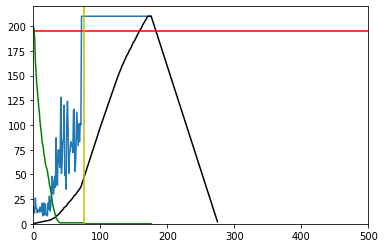

In [40]:
#Plotting
rolling_average = np.convolve(rewards, np.ones(100)/100)

plt.plot(rewards)
plt.plot(rolling_average, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
eps_graph = [200*x for x in epsilons]
plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TRAIN_END, color='y', linestyle='-')
plt.xlim( (0,EPISODES) )
plt.ylim( (0,220) )
plt.show()

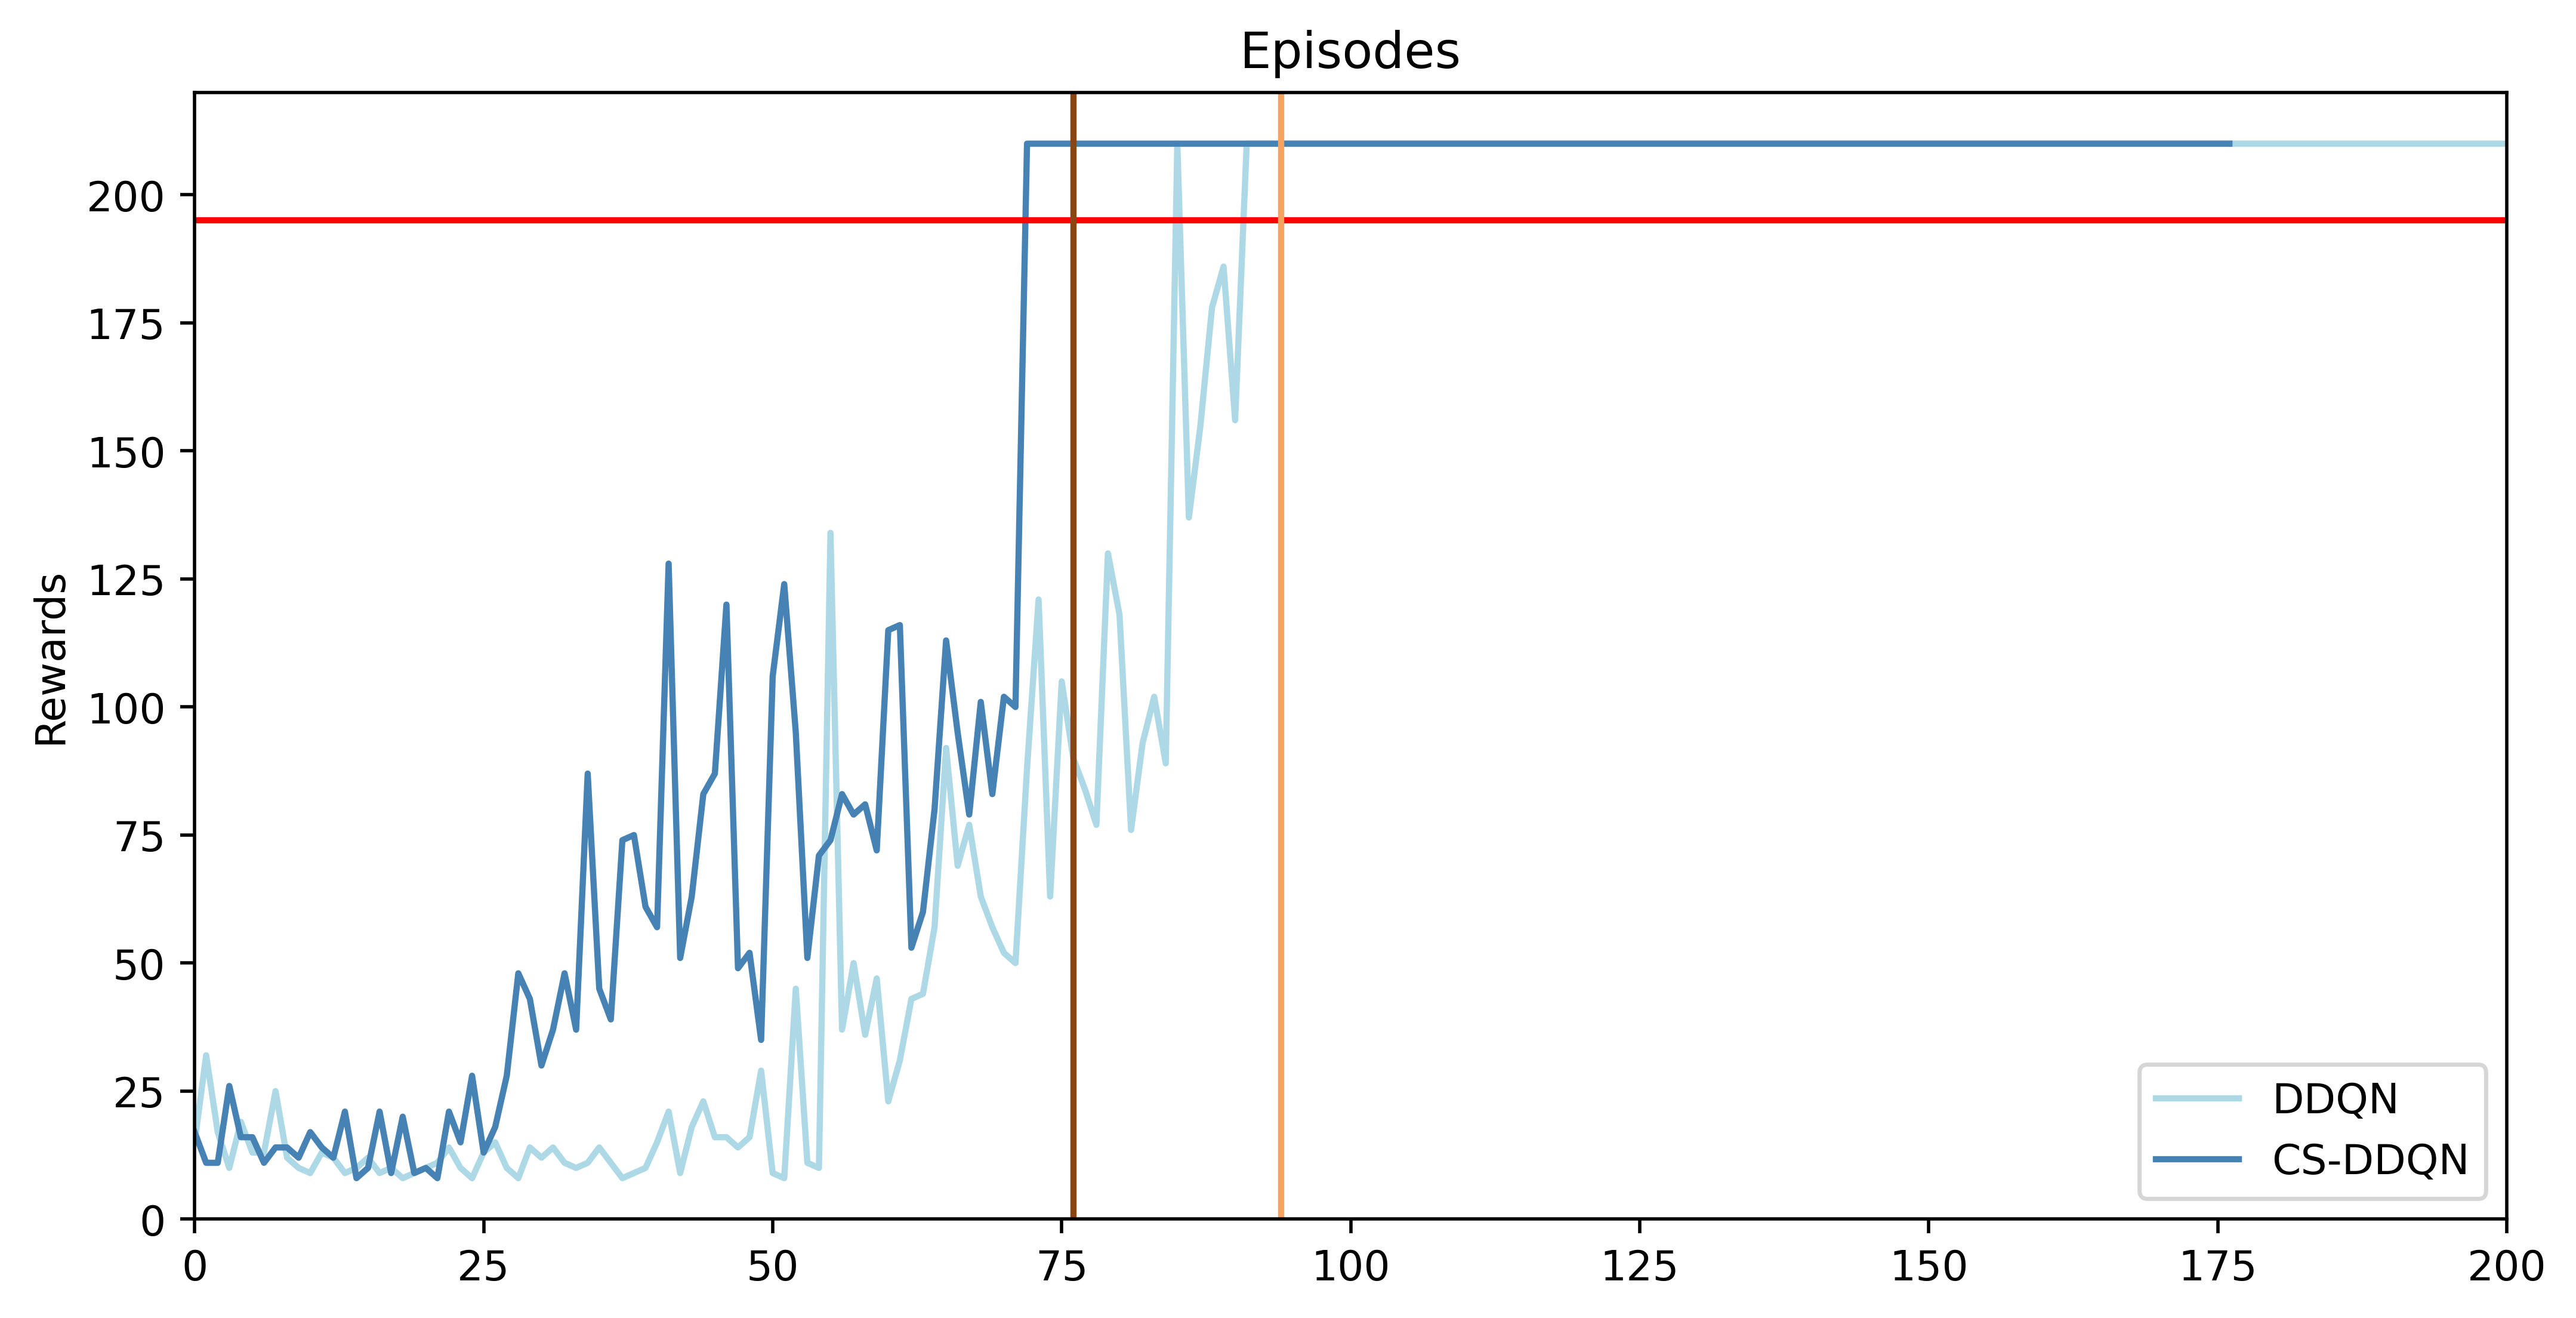

In [44]:
import numpy as np
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(10,5),dpi=500)

r_old=np.load('/content/drive/My Drive/db/dqn/ddqn/rewards.npy')
r_new=np.load('/content/drive/My Drive/db/dqn/ddqn/rewards_cs.npy')
TE_old=np.load('/content/drive/My Drive/db/dqn/ddqn/TRAIN_END.npy')
TE_new=np.load('/content/drive/My Drive/db/dqn/ddqn/TRAIN_END_cs.npy')

#rolling_average1 = np.convolve(r_old, np.ones(100)/100)
#rolling_average2 = np.convolve(r_new, np.ones(100)/100)

plt.plot(r_old, color= 'lightblue',label='DDQN')
plt.plot(r_new, color='steelblue',label='CS-DDQN')
#plt.plot(rolling_average1, color='grey')
#plt.plot(rolling_average1, color='black')
plt.axhline(y=195, color='r', linestyle='-') #Solved Line
#Scale Epsilon (0.001 - 1.0) to match reward (0 - 200) range
#eps_graph = [200*x for x in epsilons]
#plt.plot(eps_graph, color='g', linestyle='-')
#Plot the line where TESTING begins
plt.axvline(x=TE_old, color='sandybrown', linestyle='-')
plt.axvline(x=TE_new, color='saddlebrown', linestyle='-')
plt.xlim( (0,200) )
plt.ylim( (0,220) )
plt.ylabel('Rewards')
plt.title('Episodes')
plt.legend()

plt.show()